In [7]:
import os
from astropy.io import fits
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py
from keras.preprocessing.image import ImageDataGenerator
from DataMaker import *
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import keras
import os
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input, Concatenate

from photoz_utils import *
from DataMaker import *
from neptune.new.integrations.tensorflow_keras import NeptuneCallback
import neptune.new as neptune

In [8]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only allocate 10GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:

from __future__ import absolute_import

from typing import Tuple, Union, Optional

import h5py as h5
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
!pip install albumentations
from albumentations import Compose
import numpy as np

available_modes = {"train", "test"}
available_labels_encoding = {"hot", "smooth", False}


class HDF5ImageGenerator(Sequence):

    def __init__(
        self,
        src,
        #X_key="images",
        y_key="labels",
        classes_key=None,
        batch_size=200,
        shuffle=True,
        scaler=True,
        num_classes=None,
        labels_encoding="hot",
        smooth_factor=0.1,
        augmenter=False,
        mode="train",
    ):

        if mode not in available_modes:
            raise ValueError('`mode` should be `train` '
                             '(fit_generator() and evaluate_generator()) or '
                             '`test` (predict_generator(). '
                             'Received: %s' % mode)
        self.mode = mode

        if labels_encoding not in available_labels_encoding:
            raise ValueError('`labels_encoding` should be `hot` '
                             '(classic binary matrix) or '
                             '`smooth` (smooth encoding) or '
                             'False (no labels encoding). '
                             'Received: %s' % labels_encoding)
        self.labels_encoding = labels_encoding

        if (self.labels_encoding == "smooth") and not (0 < smooth_factor <= 1):
            raise ValueError('`smooth` labels encoding '
                             'must use a `smooth_factor` '
                             '< 0 smooth_factor <= 1')

        if augmenter and not isinstance(augmenter, Compose):
            raise ValueError('`augmenter` argument '
                             'must be an instance of albumentations '
                             '`Compose` class. '
                             'Received type: %s' % type(augmenter))
        self.augmenter = augmenter

        self.src: str = src
        #self.X_key: str = X_key
        self.y_key: str = y_key
        self.classes_key: str = classes_key
        self.batch_size: int = batch_size
        self.shuffle: bool = shuffle
        self.scaler: bool = scaler
        self.num_classes: int = num_classes
        self.smooth_factor: float = smooth_factor

        self._indices = np.arange(self.__get_dataset_shape(self.y_key, 0))

    def __repr__(self):
        """Representation of the class."""
        return f"{self.__class__.__name__}({self.__dict__!r})"

    def __get_dataset_shape(self, dataset: str, index: int) -> Tuple[int, ...]:
        """Get an h5py dataset shape.
        
        Arguments
        ---------
        dataset : str
            The dataset key.
        index : int
            The dataset index.
         
        Returns
        -------
        tuple of ints
            A tuple of array dimensions.
        """
        with h5.File(self.src, "r") as file:
            return file[dataset].shape[index]

    def __get_dataset_items(
        self,
        indices: np.ndarray,
        dataset: Optional[str] = None
    ) -> Union[np.ndarray, Tuple[np.ndarray]]:
        """Get an HDF5 dataset items.
        
        Arguments
        ---------
        indices : ndarray, 
            The list of current batch indices.
        dataset : (optional) str
            The dataset key. If None, returns
            a batch of (image tensors, labels).
            Defaults to None.
         
        Returns
        -------
        np.ndarray or a tuple of ndarrays
            A batch of samples.
        """
        with h5.File(self.src, "r") as file:
            if dataset is not None:
                return np.asarray(file[dataset][indices]).astype('float32')
            else:
                return np.asarray(file[self.y_key][indices]).astype('float32')
            
    
    @property
    def num_items(self) -> int:
        """Grab the total number of examples
         from the dataset.
         
        Returns
        -------
        int
            The total number of examples.
        """
        with h5.File(self.src, "r") as file:
            return file[self.y_key].shape[0]
    
    @property 
    def classes(self) -> list:
        """Grab "human" classes from the dataset.
        
        Returns
        -------
        list
            A list of the raw classes.
        """
        if self.classes_key is None:
            raise ValueError('Canceled. parameter `classes_key` '
                             'is set to None.')
        
        with h5.File(self.src, "r") as file:
            return file[self.classes_key][:]

    def __len__(self):
        """Denotes the number of batches per epoch.
         
        Returns
        -------
        int
            The number of batches per epochs.
        """
        return int(
            np.ceil(
                self.__get_dataset_shape(self.y_key, 0) /
                float(self.batch_size)))

    @staticmethod
    def apply_labels_smoothing(batch_y: np.ndarray,
                               factor: float) -> np.ndarray:
        """Applies labels smoothing to the original
         labels binary matrix.
         
        Arguments
        ---------
        batch_y : np.ndarray
            Current batch integer labels.
        factor : float
            Smoothing factor.
        
        Returns
        -------
        np.ndarray
            A binary class matrix.
        """
        batch_y *= 1 - factor
        batch_y += factor / batch_y.shape[1]

        return batch_y

    def apply_labels_encoding(
            self,
            batch_y: np.ndarray,
            smooth_factor: Optional[float] = None) -> np.ndarray:
        """Converts a class vector (integers) to binary class matrix.
         See Keras to_categorical utils function.
         
        Arguments
        ---------
        batch_y : np.ndarray
            Current batch integer labels.
        smooth_factor : (optional) Float
            Smooth factor.
            Defaults to None.
        
        Returns
        -------
        np.ndarray
            A binary class matrix.
        """
        batch_y = to_categorical(batch_y, num_classes=self.num_classes)

        if smooth_factor is not None:
            batch_y = self.apply_labels_smoothing(batch_y,
                                                  factor=smooth_factor)

        return batch_y

    @staticmethod
    def apply_normalization(batch_X: np.ndarray) -> np.ndarray:
        """Normalize the pixel intensities. 
        
        Normalize the pixel intensities to the range [0, 1].
         
        Arguments
        ---------
        batch_X : np.ndarray
            Batch of image tensors to be normalized.
        
        Returns
        -------
        np.ndarray
            A batch of normalized image tensors.
        """
        return batch_X.astype("float32") / 4.0



    def __next_batch(self,
                     indices: np.ndarray) -> Tuple[np.ndarray]:
        """Generates a batch of train/val data for the given indices.
        
        Arguments
        ---------
        index : int
            The index for the batch.
            
        Returns
        -------
        tuple of ndarrays
            A tuple containing a batch of image tensors
            and their associated labels.
        """
        # Grab samples (tensors, labels) HDF5 source file.
        (batch_y) = np.asarray(self.__get_dataset_items(indices))


        if self.labels_encoding:
            batch_y = self.apply_labels_encoding(
                batch_y,
                smooth_factor=self.smooth_factor
                if self.labels_encoding == "smooth" else None,
            )

        return (batch_y)

    def __getitem__(
            self,
            index: int) -> Union[np.ndarray, Tuple[np.ndarray]]:
        """Generates a batch of data for the given index.
        
        Arguments
        ---------
        index : int
            The index for the current batch.
            
        Returns
        -------
        tuple of ndarrays or ndarray
            A tuple containing a batch of image tensors
            and their associated labels (train) or
            a tuple of image tensors (predict).
        """
        # Indices for the current batch.
        indices = np.sort(self._indices[index * self.batch_size:(index + 1) *
                                        self.batch_size])

        if self.mode == "train":
            return self.__next_batch(indices)
        else:
            return self.__next_batch_test(indices)

    def __shuffle_indices(self):
        """If the shuffle parameter is set to True,
         dataset will be shuffled (in-place).
         (not available in test 'mode').
        """
        if (self.mode == "train") and self.shuffle:
            np.random.shuffle(self._indices)

    def on_epoch_end(self):
        """Triggered once at the very beginning as well as 
         at the end of each epoch.
        """
        self.__shuffle_indices()
        
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

IMAGE_SHAPE = (5, 127, 127)
BATCH_SIZE = 200
EPOCHS = 5
GB_LIMIT = 5

BATCH_SIZE = 200
args_gen = {'y_key': 'specz_redshift',
    'scaler': False,
    'labels_encoding': False,
    'batch_size': BATCH_SIZE,
    'mode': 'train',
    'shuffle': False}

TRAIN_PATH  = '/data/HSC/HSC_v6/step2A/127x127/divisible_training/five_band_image127x127_with_metadata_corrected_training_divisible.hdf5'
VAL_PATH = '/data/HSC/HSC_v6/step2A/127x127/divisible_training/five_band_image127x127_with_metadata_corrected_validation_divisible.hdf5'
TEST_PATH = '/data/HSC/HSC_v6/step2A/127x127/divisible_training/five_band_image127x127_with_metadata_corrected_testing_divisible.hdf5'


train_gen_label = HDF5ImageGenerator(src=TRAIN_PATH, **args_gen)
val_gen_label = HDF5ImageGenerator(src=VAL_PATH, **args_gen)
test_gen_label = HDF5ImageGenerator(src=TEST_PATH, **args_gen)

Defaulting to user installation because normal site-packages is not writeable


In [5]:

from __future__ import absolute_import

from typing import Tuple, Union, Optional

import h5py as h5
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
!pip install albumentations
from albumentations import Compose
import numpy as np

available_modes = {"train", "test"}
available_labels_encoding = {"hot", "smooth", False}


class HDF5ImageGenerator(Sequence):
    """Just a simple custom Keras HDF5 ImageDataGenerator.
    
    Custom Keras ImageDataGenerator that generates
    batches of tensor images from HDF5 files with (optional) real-time
    data augmentation.
     
    Arguments
    ---------
    src : str
        Path of the hdf5 source file.
    X_key : str
        Key of the h5 file image tensors dataset.
        Default is "images".
    y_key : str
        Key of the h5 file labels dataset.
        Default is "labels".
    classes_key : str
        Key of the h5 file dataset containing
        the raw classes.
        Default is None.
    batch_size : int
        Size of each batch, must be a power of two.
        (16, 32, 64, 128, 256, ...)
        Default is 32.
    shuffle : bool
        Shuffle images at the end of each epoch.
        Default is True.
    scaler : "std", "norm" or False
        "std" mode means standardization to range [-1, 1]
        with 0 mean and unit variance.
        "norm" mode means normalization to range [0, 1].
        Default is "std".
    num_classes : None or int
        Specifies the total number of classes
        for labels encoding.
        Default is None.
    labels_encoding : "hot", "smooth" or False
        "hot" mode means classic one hot encoding.
        "smooth" mode means smooth hot encoding.
        Default is "hot".
    smooth_factor : int or float
        smooth factor used by smooth
        labels encoding.
        Default is 0.1.
    augmenter : albumentations Compose([]) Pipeline or False
        An albumentations transformations pipeline
        to apply to each sample.
        Default is False.
    mode : str "train" or "test"
        Model generator type. "train" is used for
        fit_generator() and evaluate_generator.
        "test" is used for predict_generator().
        Default is "train".
        
    Notes
    -----
    Turn off scaler (scaler=False) if using the
    ToFloat(max_value=255) transformation from
    albumentations.
        
    Examples
    --------
    Example of usage:
    ```python
    my_augmenter = Compose([
        HorizontalFlip(p=0.5),
        RandomContrast(limit=0.2, p=0.5),
        RandomGamma(gamma_limit=(80, 120), p=0.5),
        RandomBrightness(limit=0.2, p=0.5),
        Resize(227, 227, cv2.INTER_AREA)
    ])

    # Create the generator.
    train_gen = HDF5ImageGenerator(
        'path/to/my/file.h5',
         augmenter=my_augmenter)
    ```
    """
    def __init__(
        self,
        src,
        #X_key="images",
        y_key="labels",
        classes_key=None,
        batch_size=200,
        shuffle=True,
        scaler=True,
        num_classes=None,
        labels_encoding="hot",
        smooth_factor=0.1,
        augmenter=False,
        mode="train",
    ):

        if mode not in available_modes:
            raise ValueError('`mode` should be `train` '
                             '(fit_generator() and evaluate_generator()) or '
                             '`test` (predict_generator(). '
                             'Received: %s' % mode)
        self.mode = mode

        if labels_encoding not in available_labels_encoding:
            raise ValueError('`labels_encoding` should be `hot` '
                             '(classic binary matrix) or '
                             '`smooth` (smooth encoding) or '
                             'False (no labels encoding). '
                             'Received: %s' % labels_encoding)
        self.labels_encoding = labels_encoding

        if (self.labels_encoding == "smooth") and not (0 < smooth_factor <= 1):
            raise ValueError('`smooth` labels encoding '
                             'must use a `smooth_factor` '
                             '< 0 smooth_factor <= 1')

        if augmenter and not isinstance(augmenter, Compose):
            raise ValueError('`augmenter` argument '
                             'must be an instance of albumentations '
                             '`Compose` class. '
                             'Received type: %s' % type(augmenter))
        self.augmenter = augmenter

        self.src: str = src
        #self.X_key: str = X_key
        self.y_key: str = y_key
        self.classes_key: str = classes_key
        self.batch_size: int = batch_size
        self.shuffle: bool = shuffle
        self.scaler: bool = scaler
        self.num_classes: int = num_classes
        self.smooth_factor: float = smooth_factor

        self._indices = np.arange(self.__get_dataset_shape(self.y_key, 0))

    def __repr__(self):
        """Representation of the class."""
        return f"{self.__class__.__name__}({self.__dict__!r})"

    def __get_dataset_shape(self, dataset: str, index: int) -> Tuple[int, ...]:
        """Get an h5py dataset shape.
        
        Arguments
        ---------
        dataset : str
            The dataset key.
        index : int
            The dataset index.
         
        Returns
        -------
        tuple of ints
            A tuple of array dimensions.
        """
        with h5.File(self.src, "r") as file:
            return file[dataset].shape[index]

    def __get_dataset_items(
        self,
        indices: np.ndarray,
        dataset: Optional[str] = None
    ) -> Union[np.ndarray, Tuple[np.ndarray]]:
        """Get an HDF5 dataset items.
        
        Arguments
        ---------
        indices : ndarray, 
            The list of current batch indices.
        dataset : (optional) str
            The dataset key. If None, returns
            a batch of (image tensors, labels).
            Defaults to None.
         
        Returns
        -------
        np.ndarray or a tuple of ndarrays
            A batch of samples.
        """
        with h5.File(self.src, "r") as file:
            if dataset is not None:
                return np.asarray(file[dataset][indices]).astype('float32')
            else:
                return np.asarray(file[self.y_key][indices]).astype('float32')
    
    @property
    def num_items(self) -> int:
        """Grab the total number of examples
         from the dataset.
         
        Returns
        -------
        int
            The total number of examples.
        """
        with h5.File(self.src, "r") as file:
            return file[self.y_key].shape[0]
    
    @property 
    def classes(self) -> list:
        """Grab "human" classes from the dataset.
        
        Returns
        -------
        list
            A list of the raw classes.
        """
        if self.classes_key is None:
            raise ValueError('Canceled. parameter `classes_key` '
                             'is set to None.')
        
        with h5.File(self.src, "r") as file:
            return file[self.classes_key][:]

    def __len__(self):
        """Denotes the number of batches per epoch.
         
        Returns
        -------
        int
            The number of batches per epochs.
        """
        return int(
            np.ceil(
                self.__get_dataset_shape(self.y_key, 0) /
                float(self.batch_size)))

    @staticmethod
    def apply_labels_smoothing(batch_y: np.ndarray,
                               factor: float) -> np.ndarray:
        """Applies labels smoothing to the original
         labels binary matrix.
         
        Arguments
        ---------
        batch_y : np.ndarray
            Current batch integer labels.
        factor : float
            Smoothing factor.
        
        Returns
        -------
        np.ndarray
            A binary class matrix.
        """
        batch_y *= 1 - factor
        batch_y += factor / batch_y.shape[1]

        return batch_y

    def apply_labels_encoding(
            self,
            batch_y: np.ndarray,
            smooth_factor: Optional[float] = None) -> np.ndarray:
        """Converts a class vector (integers) to binary class matrix.
         See Keras to_categorical utils function.
         
        Arguments
        ---------
        batch_y : np.ndarray
            Current batch integer labels.
        smooth_factor : (optional) Float
            Smooth factor.
            Defaults to None.
        
        Returns
        -------
        np.ndarray
            A binary class matrix.
        """
        batch_y = to_categorical(batch_y, num_classes=self.num_classes)

        if smooth_factor is not None:
            batch_y = self.apply_labels_smoothing(batch_y,
                                                  factor=smooth_factor)

        return batch_y

    @staticmethod
    def apply_normalization(batch_X: np.ndarray) -> np.ndarray:
        """Normalize the pixel intensities. 
        
        Normalize the pixel intensities to the range [0, 1].
         
        Arguments
        ---------
        batch_X : np.ndarray
            Batch of image tensors to be normalized.
        
        Returns
        -------
        np.ndarray
            A batch of normalized image tensors.
        """
        return batch_X.astype("float32") / 4.0



    def __next_batch(self,
                     indices: np.ndarray) -> Tuple[np.ndarray]:
        """Generates a batch of train/val data for the given indices.
        
        Arguments
        ---------
        index : int
            The index for the batch.
            
        Returns
        -------
        tuple of ndarrays
            A tuple containing a batch of image tensors
            and their associated labels.
        """
        # Grab samples (tensors, labels) HDF5 source file.
        (batch_y) = np.asarray(self.__get_dataset_items(indices))


        if self.labels_encoding:
            batch_y = self.apply_labels_encoding(
                batch_y,
                smooth_factor=self.smooth_factor
                if self.labels_encoding == "smooth" else None,
            )

        return (batch_y)

    def __getitem__(
            self,
            index: int) -> Union[np.ndarray, Tuple[np.ndarray]]:
        """Generates a batch of data for the given index.
        
        Arguments
        ---------
        index : int
            The index for the current batch.
            
        Returns
        -------
        tuple of ndarrays or ndarray
            A tuple containing a batch of image tensors
            and their associated labels (train) or
            a tuple of image tensors (predict).
        """
        # Indices for the current batch.
        indices = np.sort(self._indices[index * self.batch_size:(index + 1) *
                                        self.batch_size])

        if self.mode == "train":
            return self.__next_batch(indices)
        else:
            return self.__next_batch_test(indices)

    def __shuffle_indices(self):
        """If the shuffle parameter is set to True,
         dataset will be shuffled (in-place).
         (not available in test 'mode').
        """
        if (self.mode == "train") and self.shuffle:
            np.random.shuffle(self._indices)

    def on_epoch_end(self):
        """Triggered once at the very beginning as well as 
         at the end of each epoch.
        """
        self.__shuffle_indices()
        
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

IMAGE_SHAPE = (5, 127, 127)
BATCH_SIZE = 200
EPOCHS = 5
GB_LIMIT = 5

BATCH_SIZE = 200
args_gen = {'y_key': 'g_cmodel_mag',
    'scaler': False,
    'labels_encoding': False,
    'batch_size': BATCH_SIZE,
    'mode': 'train',
    'shuffle': False}



train_gen_gmag = HDF5ImageGenerator(src=TRAIN_PATH, **args_gen)
val_gen_gmag = HDF5ImageGenerator(src=VAL_PATH, **args_gen)
test_gen_gmag = HDF5ImageGenerator(src=TEST_PATH, **args_gen)

BATCH_SIZE = 200
args_gen = {'y_key': 'r_cmodel_mag',
    'scaler': False,
    'labels_encoding': False,
    'batch_size': BATCH_SIZE,
    'mode': 'train',
    'shuffle': False}


train_gen_rmag = HDF5ImageGenerator(src=TRAIN_PATH, **args_gen)
val_gen_rmag= HDF5ImageGenerator(src=VAL_PATH, **args_gen)
test_gen_rmag = HDF5ImageGenerator(src=TEST_PATH, **args_gen)

BATCH_SIZE = 200
args_gen = {'y_key': 'i_cmodel_mag',
    'scaler': False,
    'labels_encoding': False,
    'batch_size': BATCH_SIZE,
    'mode': 'train',
    'shuffle': False}


train_gen_imag = HDF5ImageGenerator(src=TRAIN_PATH, **args_gen)
val_gen_imag= HDF5ImageGenerator(src=VAL_PATH, **args_gen)
test_gen_imag = HDF5ImageGenerator(src=TEST_PATH, **args_gen)

BATCH_SIZE = 200
args_gen = {'y_key': 'z_cmodel_mag',
    'scaler': False,
    'labels_encoding': False,
    'batch_size': BATCH_SIZE,
    'mode': 'train',
    'shuffle': False}


train_gen_zmag = HDF5ImageGenerator(src=TRAIN_PATH, **args_gen)
val_gen_zmag= HDF5ImageGenerator(src=VAL_PATH, **args_gen)
test_gen_zmag = HDF5ImageGenerator(src=TEST_PATH, **args_gen)

BATCH_SIZE = 200
args_gen = {'y_key': 'y_cmodel_mag',
    'scaler': False,
    'labels_encoding': False,
    'batch_size': BATCH_SIZE,
    'mode': 'train',
    'shuffle': False}


train_gen_ymag = HDF5ImageGenerator(src=TRAIN_PATH, **args_gen)
val_gen_ymag= HDF5ImageGenerator(src=VAL_PATH, **args_gen)
test_gen_ymag = HDF5ImageGenerator(src=TEST_PATH, **args_gen)

Defaulting to user installation because normal site-packages is not writeable


In [6]:

from __future__ import absolute_import

from typing import Tuple, Union, Optional

import h5py as h5
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
!pip install albumentations
from albumentations import Compose
import numpy as np

available_modes = {"train", "test"}
available_labels_encoding = {"hot", "smooth", False}


class HDF5ImageGenerator(Sequence):
    """Just a simple custom Keras HDF5 ImageDataGenerator.
    
    Custom Keras ImageDataGenerator that generates
    batches of tensor images from HDF5 files with (optional) real-time
    data augmentation.
     
    Arguments
    ---------
    src : str
        Path of the hdf5 source file.
    X_key : str
        Key of the h5 file image tensors dataset.
        Default is "images".
    y_key : str
        Key of the h5 file labels dataset.
        Default is "labels".
    classes_key : str
        Key of the h5 file dataset containing
        the raw classes.
        Default is None.
    batch_size : int
        Size of each batch, must be a power of two.
        (16, 32, 64, 128, 256, ...)
        Default is 32.
    shuffle : bool
        Shuffle images at the end of each epoch.
        Default is True.
    scaler : "std", "norm" or False
        "std" mode means standardization to range [-1, 1]
        with 0 mean and unit variance.
        "norm" mode means normalization to range [0, 1].
        Default is "std".
    num_classes : None or int
        Specifies the total number of classes
        for labels encoding.
        Default is None.
    labels_encoding : "hot", "smooth" or False
        "hot" mode means classic one hot encoding.
        "smooth" mode means smooth hot encoding.
        Default is "hot".
    smooth_factor : int or float
        smooth factor used by smooth
        labels encoding.
        Default is 0.1.
    augmenter : albumentations Compose([]) Pipeline or False
        An albumentations transformations pipeline
        to apply to each sample.
        Default is False.
    mode : str "train" or "test"
        Model generator type. "train" is used for
        fit_generator() and evaluate_generator.
        "test" is used for predict_generator().
        Default is "train".
        
    Notes
    -----
    Turn off scaler (scaler=False) if using the
    ToFloat(max_value=255) transformation from
    albumentations.
        
    Examples
    --------
    Example of usage:
    ```python
    my_augmenter = Compose([
        HorizontalFlip(p=0.5),
        RandomContrast(limit=0.2, p=0.5),
        RandomGamma(gamma_limit=(80, 120), p=0.5),
        RandomBrightness(limit=0.2, p=0.5),
        Resize(227, 227, cv2.INTER_AREA)
    ])

    # Create the generator.
    train_gen = HDF5ImageGenerator(
        'path/to/my/file.h5',
         augmenter=my_augmenter)
    ```
    """
    def __init__(
        self,
        src,
        #X_key="images",
        y_key="labels",
        classes_key=None,
        batch_size=200,
        shuffle=True,
        scaler=True,
        num_classes=None,
        labels_encoding="hot",
        smooth_factor=0.1,
        augmenter=False,
        mode="train",
    ):

        if mode not in available_modes:
            raise ValueError('`mode` should be `train` '
                             '(fit_generator() and evaluate_generator()) or '
                             '`test` (predict_generator(). '
                             'Received: %s' % mode)
        self.mode = mode

        if labels_encoding not in available_labels_encoding:
            raise ValueError('`labels_encoding` should be `hot` '
                             '(classic binary matrix) or '
                             '`smooth` (smooth encoding) or '
                             'False (no labels encoding). '
                             'Received: %s' % labels_encoding)
        self.labels_encoding = labels_encoding

        if (self.labels_encoding == "smooth") and not (0 < smooth_factor <= 1):
            raise ValueError('`smooth` labels encoding '
                             'must use a `smooth_factor` '
                             '< 0 smooth_factor <= 1')

        if augmenter and not isinstance(augmenter, Compose):
            raise ValueError('`augmenter` argument '
                             'must be an instance of albumentations '
                             '`Compose` class. '
                             'Received type: %s' % type(augmenter))
        self.augmenter = augmenter

        self.src: str = src
        #self.X_key: str = X_key
        self.y_key: str = y_key
        self.classes_key: str = classes_key
        self.batch_size: int = batch_size
        self.shuffle: bool = shuffle
        self.scaler: bool = scaler
        self.num_classes: int = num_classes
        self.smooth_factor: float = smooth_factor

        self._indices = np.arange(self.__get_dataset_shape(self.y_key, 0))

    def __repr__(self):
        """Representation of the class."""
        return f"{self.__class__.__name__}({self.__dict__!r})"

    def __get_dataset_shape(self, dataset: str, index: int) -> Tuple[int, ...]:
        """Get an h5py dataset shape.
        
        Arguments
        ---------
        dataset : str
            The dataset key.
        index : int
            The dataset index.
         
        Returns
        -------
        tuple of ints
            A tuple of array dimensions.
        """
        with h5.File(self.src, "r") as file:
            return file[dataset].shape[index]

    def __get_dataset_items(
        self,
        indices: np.ndarray,
        dataset: Optional[str] = None
    ) -> Union[np.ndarray, Tuple[np.ndarray]]:
        """Get an HDF5 dataset items.
        
        Arguments
        ---------
        indices : ndarray, 
            The list of current batch indices.
        dataset : (optional) str
            The dataset key. If None, returns
            a batch of (image tensors, labels).
            Defaults to None.
         
        Returns
        -------
        np.ndarray or a tuple of ndarrays
            A batch of samples.
        """
        with h5.File(self.src, "r") as file:
            if dataset is not None:
                return np.asarray(file[dataset][indices]).astype('float32')
            else:
                return np.asarray(file[self.y_key][indices]).astype('float32')
    
    @property
    def num_items(self) -> int:
        """Grab the total number of examples
         from the dataset.
         
        Returns
        -------
        int
            The total number of examples.
        """
        with h5.File(self.src, "r") as file:
            return file[self.y_key].shape[0]
    
    @property 
    def classes(self) -> list:
        """Grab "human" classes from the dataset.
        
        Returns
        -------
        list
            A list of the raw classes.
        """
        if self.classes_key is None:
            raise ValueError('Canceled. parameter `classes_key` '
                             'is set to None.')
        
        with h5.File(self.src, "r") as file:
            return file[self.classes_key][:]

    def __len__(self):
        """Denotes the number of batches per epoch.
         
        Returns
        -------
        int
            The number of batches per epochs.
        """
        return int(
            np.ceil(
                self.__get_dataset_shape(self.y_key, 0) /
                float(self.batch_size)))

    @staticmethod
    def apply_labels_smoothing(batch_y: np.ndarray,
                               factor: float) -> np.ndarray:
        """Applies labels smoothing to the original
         labels binary matrix.
         
        Arguments
        ---------
        batch_y : np.ndarray
            Current batch integer labels.
        factor : float
            Smoothing factor.
        
        Returns
        -------
        np.ndarray
            A binary class matrix.
        """
        batch_y *= 1 - factor
        batch_y += factor / batch_y.shape[1]

        return batch_y

    def apply_labels_encoding(
            self,
            batch_y: np.ndarray,
            smooth_factor: Optional[float] = None) -> np.ndarray:
        """Converts a class vector (integers) to binary class matrix.
         See Keras to_categorical utils function.
         
        Arguments
        ---------
        batch_y : np.ndarray
            Current batch integer labels.
        smooth_factor : (optional) Float
            Smooth factor.
            Defaults to None.
        
        Returns
        -------
        np.ndarray
            A binary class matrix.
        """
        batch_y = to_categorical(batch_y, num_classes=self.num_classes)

        if smooth_factor is not None:
            batch_y = self.apply_labels_smoothing(batch_y,
                                                  factor=smooth_factor)

        return batch_y

    @staticmethod
    def apply_normalization(batch_X: np.ndarray) -> np.ndarray:
        """Normalize the pixel intensities. 
        
        Normalize the pixel intensities to the range [0, 1].
         
        Arguments
        ---------
        batch_X : np.ndarray
            Batch of image tensors to be normalized.
        
        Returns
        -------
        np.ndarray
            A batch of normalized image tensors.
        """
        return batch_X.astype("float32") / 4.0

    def __next_batch(self,
                     indices: np.ndarray) -> Tuple[np.ndarray]:
        """Generates a batch of train/val data for the given indices.
        
        Arguments
        ---------
        index : int
            The index for the batch.
            
        Returns
        -------
        tuple of ndarrays
            A tuple containing a batch of image tensors
            and their associated labels.
        """
        # Grab samples (tensors, labels) HDF5 source file.
        (batch_y) = np.asarray(self.__get_dataset_items(indices))


        # Shall we apply labels encoding?
        if self.labels_encoding:
            batch_y = self.apply_labels_encoding(
                batch_y,
                smooth_factor=self.smooth_factor
                if self.labels_encoding == "smooth" else None,
            )

        return (batch_y)

    def __getitem__(
            self,
            index: int) -> Union[np.ndarray, Tuple[np.ndarray]]:
        """Generates a batch of data for the given index.
        
        Arguments
        ---------
        index : int
            The index for the current batch.
            
        Returns
        -------
        tuple of ndarrays or ndarray
            A tuple containing a batch of image tensors
            and their associated labels (train) or
            a tuple of image tensors (predict).
        """
        # Indices for the current batch.
        indices = np.sort(self._indices[index * self.batch_size:(index + 1) *
                                        self.batch_size])

        if self.mode == "train":
            return self.__next_batch(indices)
        else:
            return self.__next_batch_test(indices)

    def __shuffle_indices(self):
        """If the shuffle parameter is set to True,
         dataset will be shuffled (in-place).
         (not available in test 'mode').
        """
        if (self.mode == "train") and self.shuffle:
            np.random.shuffle(self._indices)

    def on_epoch_end(self):
        """Triggered once at the very beginning as well as 
         at the end of each epoch.
        """
        self.__shuffle_indices()
        
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

IMAGE_SHAPE = (5, 127, 127)
BATCH_SIZE = 200
EPOCHS = 5
GB_LIMIT = 5

BATCH_SIZE = 200
args_gen = {'y_key': 'image',
    'scaler': False,
    'labels_encoding': False,
    'batch_size': BATCH_SIZE,
    'mode': 'train',
    'shuffle': False}


train_gen_image = HDF5ImageGenerator(src=TRAIN_PATH, **args_gen)
val_gen_image = HDF5ImageGenerator(src=VAL_PATH, **args_gen)
test_gen_image = HDF5ImageGenerator(src=TEST_PATH, **args_gen)

Defaulting to user installation because normal site-packages is not writeable


In [7]:
photozdata = h5py.File('../../data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_with_metadata_corrected_validation.hdf5', 'r')
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

spectro_z = np.asarray(photozdata["specz_redshift"])
col1 = np.asarray(photozdata["g_cmodel_mag"])
col2 = np.asarray(photozdata["r_cmodel_mag"])
col3 = np.asarray(photozdata["i_cmodel_mag"])
col4 =np.asarray(photozdata["z_cmodel_mag"])
col5 = np.asarray(photozdata["y_cmodel_mag"])
specz_err = np.asarray(photozdata["specz_redshift_err"])
gmag_err = np.asarray(photozdata["g_cmodel_magsigma"])
ymag_err = np.asarray(photozdata["y_cmodel_magsigma"])

photodata = {'col1':col1,
             'col2':col2,
             'col3':col3,
             'col4':col4,
             'col5':col5,
             'specz_err': specz_err,
             'gmag_err':gmag_err,
             'ymag_err':ymag_err,
             'specz':spectro_z
}


df = pd.DataFrame(photodata)
photodata = df

photodata.replace(-99., np.nan, inplace=True)
photodata.replace(-99.9, np.nan, inplace=True)
photodata.replace(np.inf, np.nan, inplace=True)
photodata= photodata.dropna(how='any')
specz_err = photodata['specz_err']
spectro_z = photodata['specz']
gmag_err = photodata['gmag_err']
ymag_err = photodata['ymag_err']
photodata = photodata.drop("specz", axis=1)
photodata = photodata.drop("specz_err", axis =1)
photodata = photodata.drop("gmag_err", axis =1)
photodata = photodata.drop("ymag_err", axis =1)

print(len(photodata))
photodata1 = np.array(photodata)
#normalize
photodata = min_max_scaler.fit_transform(photodata)
photozdata.close()
x_train_mags_scaled = photodata
#x_train_mags_scaled ,x_test_mags_scaled,y_train2,y_test2 = train_test_split(photodata,random_state=42,test_size=0.0)
y_train = spectro_z

42960


In [4]:
len(y_train)

200481

In [7]:


import tensorflow_probability as tfp
tfd = tfp.distributions
def posterior_mean_field(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype, initializer=lambda shape, dtype: random_gaussian_initializer(shape, dtype), trainable=True),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                       scale= + 10e-4*tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])



def prior_trainable(kernel_size: int, bias_size: int, dtype: any) -> tf.keras.Model:
    """Specify the prior over `keras.layers.Dense` `kernel` and `bias`."""
    n = kernel_size + bias_size

    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),  # Returns a trainable variable of shape n, regardless of input
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])
#USE SKIP CONNECTION:
def random_gaussian_initializer(shape, dtype):
    n = int(shape / 2)
    loc_norm = tf.random_normal_initializer(mean=0., stddev=0.1)
    loc = tf.Variable(
        initial_value=loc_norm(shape=(n,), dtype=dtype)
    )
    scale_norm = tf.random_normal_initializer(mean=-3., stddev=0.1)
    scale = tf.Variable(
        initial_value=scale_norm(shape=(n,), dtype=dtype)
    )
    return tf.concat([loc, scale], 0)

def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)



from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model


input1_ = tf.keras.layers.Input(shape=(5,127,127))
input2_ = tf.keras.layers.Input(shape=(5,))


#CNN
conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3),activation='tanh', padding='same', data_format='channels_first')(input1_)
pooling1 = tf.keras.layers.MaxPooling2D(pool_size = (2,2),data_format='channels_first')(conv1)
conv2 =tf.keras.layers.Conv2D(32, kernel_size=(2, 2),activation='tanh', padding='same', data_format='channels_first')(pooling1)
pooling2 = tf.keras.layers.MaxPooling2D(pool_size = (2,2),data_format='channels_first')(conv2)

conv3 = tf.keras.layers.Conv2D(32, kernel_size=(2, 2),activation='relu', padding='same', data_format='channels_first')(pooling2)
conv4 = tf.keras.layers.Conv2D(32, kernel_size=(2,2 ),activation='relu', padding='same', data_format='channels_first')(conv3)
flatten = tf.keras.layers.Flatten()(conv4)

dense1 = tfp.layers.DenseVariational(400, activation="tanh",make_posterior_fn=posterior_mean_field,
                                      make_prior_fn=prior_trainable,
                                      kl_weight=1 / len(y_train))(flatten)
dense2 = tfp.layers.DenseVariational(200, activation="tanh",make_posterior_fn=posterior_mean_field,
                                      make_prior_fn=prior_trainable,
                                      kl_weight=1 / len(y_train))(dense1)

#NN regression:

hidden1 = tf.keras.layers.Dense(200, activation="relu")(input2_)
hidden2 = tf.keras.layers.Dense(200, activation="relu")(hidden1)
hidden3 = tf.keras.layers.Dense(200, activation="relu")(hidden2)
hidden4 = tf.keras.layers.Dense(200, activation="relu")(hidden3)


#combine both outputs
concat = tf.keras.layers.Concatenate()([dense2, hidden4])
distribution_params = tf.keras.layers.Dense(units=2)(concat)
output = tfp.layers.IndependentNormal(1)(distribution_params)

#output = tf.keras.layers.Dense(1)(concat)

model = tf.keras.Model(inputs=[input1_,input2_],outputs = [output])


model.summary()    


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5, 127, 127) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 127, 127) 1472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 63, 63)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 63, 63)   4128        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [8]:
class JoinedMags(tf.keras.utils.Sequence):
    def __init__(self, input_gen1, input_gen2, input_gen3,input_gen4,input_gen5):
        self.gen1 = input_gen1
        self.gen2 = input_gen2
        self.gen3 = input_gen3
        self.gen4 = input_gen4        
        self.gen5 = input_gen5

        #assert len(input_gen1) == len(input_gen2) == len(target_gen)

    def __len__(self):
        return len(self.gen1)

    def __getitem__(self, i):
        x1 = self.gen1[i]
        x2 = self.gen2[i]
        x3 = self.gen3[i]
        x4 = self.gen4[i]
        x5 = self.gen5[i]

        return np.column_stack([x1, x2, x3, x4, x5])
    def on_epoch_end(self):
        self.gen1.on_epoch_end()
        self.gen2.on_epoch_end()
        self.gen3.on_epoch_end()
        self.gen4.on_epoch_end()
        self.gen5.on_epoch_end()


In [10]:

class JoinedGen(tf.keras.utils.Sequence):
    def __init__(self, input_gen1, input_gen2, target_gen):
        self.gen1 = input_gen1
        self.gen2 = input_gen2
        self.gen3 = target_gen

        #assert len(input_gen1) == len(input_gen2) == len(target_gen)

    def __len__(self):
        return len(self.gen1)

    def __getitem__(self, i):
        x1 = self.gen1[i]
        x2 = self.gen2[i]
        y = self.gen3[i]

        return [x1, x2], y

    def on_epoch_end(self):
        self.gen1.on_epoch_end()
        self.gen2.on_epoch_end()
        self.gen3.on_epoch_end()

val_mags2 = JoinedMags(val_gen_gmag,val_gen_rmag,val_gen_imag,val_gen_zmag,val_gen_ymag)
val_my_gen = JoinedGen(val_gen_image, val_mags2, val_gen_label)

In [11]:
#for neptune ai

# params = {"lr": 0.0001, "epochs": 1000}

# run = neptune.init(
#     project="astro-data-lab/BCNN",
#     api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4NDU0YjdhYy01NjM4LTQwMDQtOGQxMC02YTQ2MDkyMzQ5MmUifQ==",
# )  # your credentials
# run["parameters"] = params
# neptune_cbk = NeptuneCallback(run=run, base_namespace="training")

https://app.neptune.ai/astro-data-lab/BCNN/e/BCNN-8
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [12]:

from photoz_utils import *
optimizer = tf.keras.optimizers.Adam(learning_rate=params["lr"])
model.compile(optimizer=optimizer, loss=negative_loglikelihood,metrics=[tf.keras.metrics.RootMeanSquaredError()])


https://app.neptune.ai/astro-data-lab/Bayesian-CNN/e/BAY-22
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Epoch 1/100
1000/1000 [==============================] - ETA: 0s - loss: 1045.8564 - root_mean_squared_error: 0.0647
Epoch 00001: loss improved from inf to 1045.85645, saving model to evan_checkpoints/cp5.ckpt
1000/1000 [==============================] - 432s 431ms/step - loss: 1045.8564 - root_mean_squared_error: 0.0647 - val_loss: 1060.1315 - val_root_mean_squared_error: 0.2394
Epoch 2/100
1000/1000 [==============================] - ETA: 0s - loss: 1044.3706 - root_mean_squared_error: 0.0706
Epoch 00002: loss improved from 1045.85645 to 1044.37061, saving model to evan_checkpoints/cp5.ckpt
1000/1000 [==============================] - 501s 501ms/step - loss: 1044.3706 - root_mean_squared_error: 0.0706 - val_los

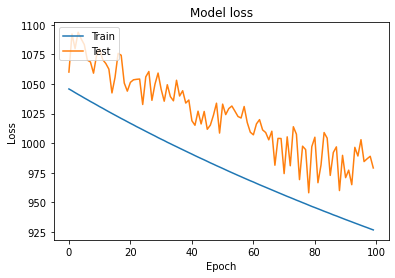

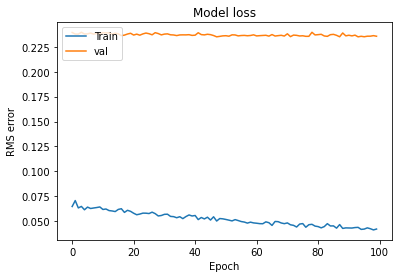

In [18]:
tf.config.experimental_run_functions_eagerly(True)
import tensorflow.keras as keras
checkpoint_path = 'evan_checkpoints/cp5.ckpt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 monitor='loss',
                                                 verbose=1,
                                                 save_freq = 1000,
                                                 save_best_only=True)
mags = np.column_stack([train_gen_gmag,train_gen_rmag,train_gen_imag,train_gen_zmag,train_gen_ymag])

mags2 = zip(train_gen_gmag,train_gen_rmag,train_gen_imag,train_gen_zmag,train_gen_ymag)
class JoinedGen(tf.keras.utils.Sequence):
    def __init__(self, input_gen1, input_gen2, target_gen):
        self.gen1 = input_gen1
        self.gen2 = input_gen2
        self.gen3 = target_gen

        #assert len(input_gen1) == len(input_gen2) == len(target_gen)

    def __len__(self):
        return len(self.gen1)

    def __getitem__(self, i):
        x1 = self.gen1[i]
        x2 = self.gen2[i]
        y = self.gen3[i]

        return [x1, x2], y

    def on_epoch_end(self):
        self.gen1.on_epoch_end()
        self.gen2.on_epoch_end()
        self.gen3.on_epoch_end()
log_dir = os.path.join("tf_logs/")
mags2 = JoinedMags(train_gen_gmag,train_gen_rmag,train_gen_imag,train_gen_zmag,train_gen_ymag)
my_gen = JoinedGen(train_gen_image, mags2, train_gen_label)
params = {"lr": 0.001, "epochs": 100}

run = neptune.init(
    project="astro-data-lab/Bayesian-CNN",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4NDU0YjdhYy01NjM4LTQwMDQtOGQxMC02YTQ2MDkyMzQ5MmUifQ==",
)  # your credentials
run["parameters"] = params
neptune_cbk = NeptuneCallback(run=run, base_namespace="training")


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(my_gen,epochs=100,shuffle= True,verbose=1, validation_data = val_my_gen, callbacks = [tensorboard_callback, cp_callback])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Test'],loc='upper left')
plt.show()
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model loss')
plt.ylabel('RMS error')
plt.xlabel('Epoch')
plt.legend(['Train','val'],loc='upper left')
plt.show()

https://app.neptune.ai/astro-data-lab/Bayesian-CNN/e/BAY-23
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Epoch 1/100
1000/1000 [==============================] - ETA: 0s - loss: 925.7492 - root_mean_squared_error: 0.0451
Epoch 00001: loss improved from inf to 925.74921, saving model to evan_checkpoints/cp5.ckpt
1000/1000 [==============================] - 491s 490ms/step - loss: 925.7492 - root_mean_squared_error: 0.0451 - val_loss: 988.9055 - val_root_mean_squared_error: 0.2360
Epoch 2/100
1000/1000 [==============================] - ETA: 0s - loss: 924.8826 - root_mean_squared_error: 0.0438
Epoch 00002: loss improved from 925.74921 to 924.88263, saving model to evan_checkpoints/cp5.ckpt
1000/1000 [==============================] - 532s 532ms/step - loss: 924.8826 - root_mean_squared_error: 0.0438 - val_loss: 960.9

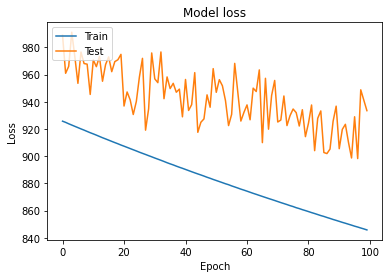

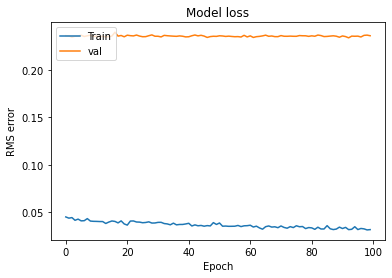

In [19]:
tf.config.experimental_run_functions_eagerly(True)
import tensorflow.keras as keras
checkpoint_path = 'evan_checkpoints/cp5.ckpt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 monitor='loss',
                                                 verbose=1,
                                                 save_freq = 1000,
                                                 save_best_only=True)
mags = np.column_stack([train_gen_gmag,train_gen_rmag,train_gen_imag,train_gen_zmag,train_gen_ymag])

mags2 = zip(train_gen_gmag,train_gen_rmag,train_gen_imag,train_gen_zmag,train_gen_ymag)
class JoinedGen(tf.keras.utils.Sequence):
    def __init__(self, input_gen1, input_gen2, target_gen):
        self.gen1 = input_gen1
        self.gen2 = input_gen2
        self.gen3 = target_gen

        #assert len(input_gen1) == len(input_gen2) == len(target_gen)

    def __len__(self):
        return len(self.gen1)

    def __getitem__(self, i):
        x1 = self.gen1[i]
        x2 = self.gen2[i]
        y = self.gen3[i]

        return [x1, x2], y

    def on_epoch_end(self):
        self.gen1.on_epoch_end()
        self.gen2.on_epoch_end()
        self.gen3.on_epoch_end()
log_dir = os.path.join("tf_logs/")
mags2 = JoinedMags(train_gen_gmag,train_gen_rmag,train_gen_imag,train_gen_zmag,train_gen_ymag)
my_gen = JoinedGen(train_gen_image, mags2, train_gen_label)
params = {"lr": 0.001, "epochs": 100}

run = neptune.init(
    project="astro-data-lab/Bayesian-CNN",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4NDU0YjdhYy01NjM4LTQwMDQtOGQxMC02YTQ2MDkyMzQ5MmUifQ==",
)  # your credentials
run["parameters"] = params
neptune_cbk = NeptuneCallback(run=run, base_namespace="training")


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(my_gen,epochs=100,shuffle= True,verbose=1, validation_data = val_my_gen, callbacks = [tensorboard_callback, cp_callback])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Test'],loc='upper left')
plt.show()
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model loss')
plt.ylabel('RMS error')
plt.xlabel('Epoch')
plt.legend(['Train','val'],loc='upper left')
plt.show()

In [ ]:
#evaluate model here:

model.load_weights('evan_checkpoints/cp5.ckpt')

photoz_arr = []
std_arr = []
sample_arr = []
for i in range(len(test_gen_label)):
    mags = np.column_stack([test_gen_gmag[i],test_gen_rmag[i],test_gen_imag[i],test_gen_zmag[i],test_gen_ymag[i]])
    evaluated_model_i = model([test_gen_image[i], mags])
    predict_i = model.predict([test_gen_image[i], mags])
    prediction_mean_i = (evaluated_model_i.mean()).numpy().tolist()

    prediction_stdv_i = (evaluated_model_i.stddev()).numpy()
    sample_arr.append(np.ravel(predict_i))
    photoz_arr.append(np.ravel(prediction_mean_i))
    std_arr.append(np.ravel(prediction_stdv_i))


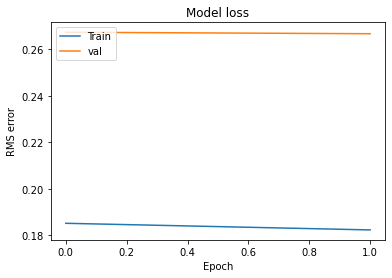

In [22]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model loss')
plt.ylabel('RMS error')
plt.xlabel('Epoch')
plt.legend(['Train','val'],loc='upper left')

In [22]:
from photoz_utils import *
y_test_new = pd.Series(np.ravel(y_test))
photoz = pd.Series(np.ravel(photoz_arr))
get_point_metrics(photoz,y_test_new)

,zspec_bin,count,L,bias_bw,bias_conv,scatter_bw,scatter_conv,outlier_bw,outlier_conv
0,"(0.0, 4.0]",43000,0.104205,-0.013181,-0.012612,0.035045,0.030702,0.142372,0.065977


In [13]:
model.save_weights('./checkpoints/bcnn_with_mags_optimal_model_old_loss_10_4_22')